In [159]:
import pandas as pd
import geopandas as gpd
import shapely as sp

# Config

In [160]:
# true leading and trailing edge datasets
lead = pd.read_excel('edge_data_for_christian.xlsx')
trail = pd.read_excel('trailing_edge_data_for_christian.xlsx')

In [161]:
trail['estimated_2019'] = trail.intercept + 2019 * trail.slope
lead['estimated_2019'] = lead.intercept + 2019 * lead.slope

trail = trail.loc[trail.end_year >= 2014].reset_index(drop = True)
lead = lead.loc[lead.end_year >= 2014].reset_index(drop = True)

# obtain all fish scientific names for species we have Aquamaps data for
fishnames = pd.read_csv('species_lists/fish_fullnames.csv')
missing = pd.read_csv('species_lists/missing_species.csv')

missing['sci_name'] = [f"{missing.genus[i]} {missing.species[i]}" for i in range(len(missing))]
fishnames['sci_name'] = [f"{fishnames.genus[i]} {fishnames.species[i]}" for i in range(len(fishnames))]
f = fishnames.loc[~fishnames.sci_name.isin(missing.sci_name)].reset_index(drop = True)

# restrict dataframes trail and head to only include fish listed in f
trail = trail.loc[trail.accepted_name.isin(f.sci_name)].reset_index(drop = True)
lead = lead.loc[lead.accepted_name.isin(f.sci_name)].reset_index(drop = True)

trail['most_recent'] = trail.intercept + trail.end_year * trail.slope
lead['most_recent'] = lead.intercept + lead.end_year * lead.slope

In [162]:
len(lead), len(trail)

(1746, 1720)

In [163]:
for df in [lead, trail]:
    print(f"length: {len(df)}, missing coastal info: {(df.ocean_continent == 'NA-NA').mean()})")

length: 1746, missing coastal info: 0.045819014891179836)
length: 1720, missing coastal info: 0.04825581395348837)


In [164]:
lead = lead.loc[lead.ocean_continent != 'NA-NA'].reset_index(drop = True)
trail = trail.loc[trail.ocean_continent != 'NA-NA'].reset_index(drop = True)

In [165]:
lead.head()

,accepted_name,ocean_continent,survey,season,start_year,end_year,edge,slope,intercept,estimated_2019,most_recent
0,Acantholabrus palloni,Atlantic Ocean-Europe,PT-IBTS,NaN,2005,2017,Leading Edge,0.009666,21.856607,41.371393,41.352062
1,Aetobatus narinari,Atlantic Ocean-North America,SEUS,FALL,1998,2018,Leading Edge,0.030151,-28.391677,32.483915,32.453764
2,Agonus cataphractus,Atlantic Ocean-Europe,BITS,NaN,1999,2020,Leading Edge,0.001674,53.870487,57.251258,57.252932
3,Agonus cataphractus,Atlantic Ocean-Europe,FR-CGFS,NaN,1998,2020,Leading Edge,0.002496,45.939992,50.980357,50.982853
4,Agonus cataphractus,Atlantic Ocean-Europe,IE-IGFS,NaN,2003,2019,Leading Edge,0.042313,-29.421084,56.009502,56.009502


In [166]:
# only keep the highest predicted latitude on a given coast for the leaders
grouped_lead = lead.groupby(by = ['accepted_name', 'ocean_continent']).estimated_2019.max()

# only keep lowest predicted latitude on a given coast for the trailers
grouped_trail = trail.groupby(by = ['accepted_name', 'ocean_continent']).estimated_2019.min()

In [167]:
keep = []
for i in range(len(lead)):
    name = lead.accepted_name.loc[i]
    coast = lead.ocean_continent.loc[i]
    if lead.estimated_2019.loc[i] == grouped_lead.loc[(name, coast)]:
        keep.append(i)
lead = lead.loc[keep].reset_index(drop = True)

In [168]:
keep = []
for i in range(len(trail)):
    name = trail.accepted_name.loc[i]
    coast = trail.ocean_continent.loc[i]
    if trail.estimated_2019.loc[i] == grouped_trail.loc[(name, coast)]:
        keep.append(i)
trail = trail.loc[keep].reset_index(drop = True)

# Preparing shape file

In [169]:
'''import requests
import zipfile
import io
import os

# URL of the ZIP file
zip_url = "https://github.com/AquaAuma/TrawlSurveyMetadata/archive/refs/heads/master.zip"

# Directory to extract the files
extract_dir = "metadata_files"

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download the ZIP file
response = requests.get(zip_url)

# Check if download was successful
if response.status_code == 200:
    # Open the ZIP file
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        # Extract all contents
        zip_ref.extractall(extract_dir)
    print("Files downloaded and extracted successfully!")
else:
    print("Failed to download the ZIP file.")'''

'import requests\nimport zipfile\nimport io\nimport os\n\n# URL of the ZIP file\nzip_url = "https://github.com/AquaAuma/TrawlSurveyMetadata/archive/refs/heads/master.zip"\n\n# Directory to extract the files\nextract_dir = "metadata_files"\n\n# Create the directory if it doesn\'t exist\nos.makedirs(extract_dir, exist_ok=True)\n\n# Download the ZIP file\nresponse = requests.get(zip_url)\n\n# Check if download was successful\nif response.status_code == 200:\n    # Open the ZIP file\n    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:\n        # Extract all contents\n        zip_ref.extractall(extract_dir)\n    print("Files downloaded and extracted successfully!")\nelse:\n    print("Failed to download the ZIP file.")'

In [170]:
# Read the shapefile into a GeoDataFrame
survey_regions = gpd.read_file('metadata/Metadata_18062020.shp')
survey_regions.Survey.loc[survey_regions.Survey == 'Gulf of Mexico'] = 'GMEX'
survey_regions.Survey.loc[survey_regions.Survey == 'Northeast US'] = 'NEUS'
survey_regions.Survey.loc[survey_regions.Survey == 'Scotian Shelf'] = 'SCS'
survey_regions.Survey.loc[survey_regions.Survey == 'Southeast US'] = 'SEUS'

/var/folders/0j/mks53s7x7j16858sp0whvcdc0000gn/T/ipykernel_62131/3489283857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_regions.Survey.loc[survey_regions.Survey == 'Gulf of Mexico'] = 'GMEX'
/var/folders/0j/mks53s7x7j16858sp0whvcdc0000gn/T/ipykernel_62131/3489283857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_regions.Survey.loc[survey_regions.Survey == 'Northeast US'] = 'NEUS'
/var/folders/0j/mks53s7x7j16858sp0whvcdc0000gn/T/ipykernel_62131/3489283857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

In [171]:
from shapely.geometry import Polygon, MultiPolygon

def check_overlap(poly1, poly2):
    """
    Check if two polygons or multipolygons overlap.

    Args:
    poly1 (Polygon or MultiPolygon): First polygon or multipolygon.
    poly2 (Polygon or MultiPolygon): Second polygon or multipolygon.

    Returns:
    bool: True if poly1 overlaps with poly2, False otherwise.
    """
    # Convert polygons to MultiPolygon if they are not already
    if not isinstance(poly1, MultiPolygon):
        poly1 = MultiPolygon([poly1])
    if not isinstance(poly2, MultiPolygon):
        poly2 = MultiPolygon([poly2])
    
    # Check if there is any intersection between the polygons
    return poly1.intersects(poly2)

# Example usage:
# overlap = check_overlap(polygon1, polygon2)
# print(overlap)

In [172]:
gdf = gpd.read_file('/Users/jameswagner/Dropbox/Mac/Desktop/Fish Ranges/MEOW/meow_ecos.shp')

In [173]:
# defining north-american ecoregion id's in an np array
atlantic_namer = [63, 42, 62, 38, 39, 40, 41, 42, 5, 6, 7]
# gulf of mexico: 69, 43, 70
# caribbearn: 67, 68, 65, 64

atlantic_euro = [27, 26, 25, 24, 21, 22, 23]
# iceland: 20, 2
# mediterranean: 30, 31, 32, 33, 34, 35, 36


pacific_namer = [170, 168, 167, 166, 164,
                60, 61, 59, 58, 57, 56, 55, 54]
# Clipperton: 165
# Cocos Islands: 169
# Aleutian Islands: 53
# bearing sea: 14

In [174]:
gdf.loc[gdf.ECO_CODE_X == 29]

,ECO_CODE,ECOREGION,PROV_CODE,PROVINCE,RLM_CODE,REALM,ALT_CODE,ECO_CODE_X,Lat_Zone,geometry
13,20029.0,Azores Canaries Madeira,3.0,Lusitanian,2.0,Temperate Northern Atlantic,36.0,29.0,Temperate,"MULTIPOLYGON (((-16.39408 26.37686, -19.20883 ..."


In [175]:
gdf.columns

Index(['ECO_CODE', 'ECOREGION', 'PROV_CODE', 'PROVINCE', 'RLM_CODE', 'REALM',
       'ALT_CODE', 'ECO_CODE_X', 'Lat_Zone', 'geometry'],
      dtype='object')

In [176]:
coast_labels = [None] * len(gdf)
ecoregions = ['atl_euro', 'atl_namer', 'pac_namer']
for i,code in enumerate(gdf.ECO_CODE_X):
    if code in atlantic_namer:
        coast_labels[i] = ecoregions[1]
    elif code in pacific_namer:
        coast_labels[i] = ecoregions[2]
    elif code in atlantic_euro:
        coast_labels[i] = ecoregions[0]

In [177]:
gdf['coast'] = coast_labels

In [178]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [179]:
coastal_gdf = gdf.groupby('coast')
coast_geoms = coastal_gdf['geometry'].apply(sp.unary_union)
coast_gdf = gpd.GeoDataFrame(geometry=coast_geoms, crs=gdf.crs)

In [180]:
coast_gdf.loc['atl_euro']

geometry    POLYGON ((-11.89763 35.42278, -11.95614 35.546...
Name: atl_euro, dtype: geometry

<Axes: >

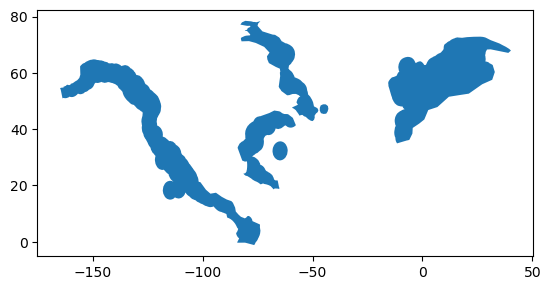

In [181]:
coast_gdf.plot()

In [182]:
coast_gdf.head()

,geometry
coast,
atl_euro,"POLYGON ((-11.89763 35.42278, -11.95614 35.546..."
atl_namer,"MULTIPOLYGON (((-66.14586 21.77450, -66.06586 ..."
pac_namer,"POLYGON ((-76.30694 -0.88693, -76.45799 -1.111..."


In [183]:
# create new gdf that is the intersection of coast_gdf and the survey one

In [184]:
all_surveys = pd.Series(pd.Series(list(lead.survey) + list(trail.survey)).unique())

In [185]:
lead.survey.unique()

array(['PT-IBTS', 'SEUS', 'NS-IBTS', 'GOA', 'GMEX', 'WCANN', 'NEUS',
       'GSL-S', 'SCS', 'DFO-WCVI', 'Nor-BTS', 'GSL-N', 'DFO-HS', 'BITS',
       'EBS', 'IE-IGFS', 'EVHOE', 'AI', 'DFO-WCHG', 'SWC-IBTS', 'FR-CGFS',
       'NIGFS', 'DFO-QCS'], dtype=object)

In [186]:
represented_regions = survey_regions.loc[survey_regions.Survey.isin(all_surveys)].reset_index(drop = True)

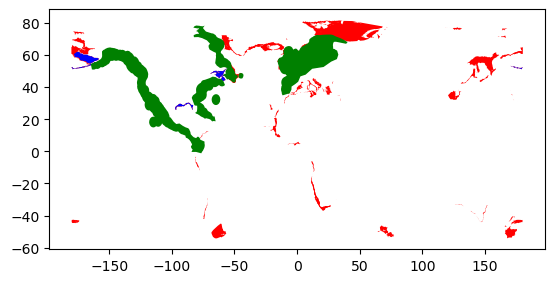

In [187]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have GeoDataFrames `all_surveys` and `represented_regions` defined

# Create a new plot
fig, ax = plt.subplots()

# Plot all_surveys with red color
survey_regions.plot(ax=ax, color='red')

# Plot represented_regions with blue color, overlaying on the same plot
represented_regions.plot(ax=ax, color='blue')

coast_gdf.plot(ax=ax, color='green')

# Show the plot
plt.show()

In [188]:
p1 = represented_regions.geometry[0]
p2 = cdf.geometry[0]

# assign a coast to each of the represented survey regions in the dataset (NAMER pacific, NAMER atlantic, EURO atlantic)

In [189]:
coast_colors = ['red', 'blue', 'green']
coasts = coast_gdf.reset_index()

In [190]:
overlap = [False] * len(represented_regions)
overlapping_coast = [None] * len(represented_regions)

In [191]:
coasts

,coast,geometry
0,atl_euro,"POLYGON ((-11.89763 35.42278, -11.95614 35.546..."
1,atl_namer,"MULTIPOLYGON (((-66.14586 21.77450, -66.06586 ..."
2,pac_namer,"POLYGON ((-76.30694 -0.88693, -76.45799 -1.111..."


In [192]:
euro = [check_overlap(coasts.geometry[0], map) for  map in represented_regions.geometry]

In [193]:
east_coast = [check_overlap(coasts.geometry[1], map) for  map in represented_regions.geometry]

In [194]:
west_coast = [check_overlap(coasts.geometry[2], map) for  map in represented_regions.geometry]

In [195]:
for i in range(len(represented_regions)):
    if euro[i]:
        cont = 'atl_euro'
        overlapping_coast[i] = cont
    elif east_coast[i]:
        cont = 'atl_namer'
        overlapping_coast[i] = cont
    elif west_coast[i]:
        cont = 'pac_namer'
        overlapping_coast[i] = cont

In [196]:
overlapping_coast

['atl_euro',
 'atl_euro',
 'pac_namer',
 'pac_namer',
 'atl_euro',
 'atl_euro',
 'atl_euro',
 'atl_euro',
 'atl_euro',
 'atl_euro',
 None,
 'atl_namer',
 'atl_namer',
 'atl_namer',
 'pac_namer',
 'pac_namer',
 'pac_namer',
 None,
 'atl_namer',
 None,
 None,
 'pac_namer']

In [197]:
represented_regions['coast'] = overlapping_coast

In [198]:
coastal_gdf = represented_regions.groupby('coast')
coast_geoms = coastal_gdf['geometry'].apply(sp.unary_union)
coast_gdf = gpd.GeoDataFrame(geometry=coast_geoms, crs=gdf.crs)

<Axes: >

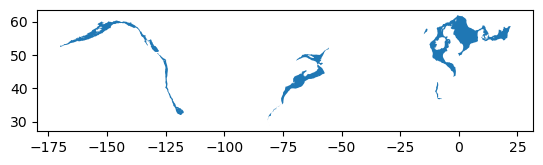

In [199]:
coast_gdf.plot()

# Prepare ECDF's for each coast in question

In [200]:
#Atlantic Europe, Atlantic North America, Pacific North America
ECDF = [{},{},{}]
HD_ECDF = [{},{},{}]

In [201]:
prob_cutoff = 0.80

In [202]:
ecoregions

['atl_euro', 'atl_namer', 'pac_namer']

In [203]:
for i in range(len(f)):
    g = f.genus.loc[i].lower()
    s = f.species.loc[i].lower()
    filepath = f'fish_data/{g}_{s}.csv'
    full_map = pd.read_csv(filepath)

    # subdivide into each of the three coastal regional maps
    points = [sp.Point(lat, lon) for lon,lat in zip(full_map['Center Lat'], full_map['Center Long'])]
    maps = []
    for ecoreg in ecoregions:
        maps.append(full_map.loc[coast_gdf.loc[ecoreg].geometry.contains(points)])
        # fills the maps in the following order: Atlantic Europe, Atlantic North America, Pacific North America

    # calculate north-south ecdfs for each map
    for j,map in enumerate(maps):
        net_density = map.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
        net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
        net_density['ECDF'] = net_density['PMF'].cumsum()

        ECDF[j][f.sci_name.loc[i]] = net_density[['Center Lat', 'ECDF']]
        ECDF[j][f.sci_name.loc[i]].columns = ['latitude', 'ecdf']


    
    # repeat for only cells with probability higher than the specified prob_cutoff
    hd_maps = []
    for map in maps:
        hd_maps.append(map.loc[map['Overall Probability'] >= prob_cutoff].reset_index(drop=True))

    # calculate north-south ecdfs for each map
    for j,map in enumerate(hd_maps):
        net_density = map.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
        net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
        net_density['ECDF'] = net_density['PMF'].cumsum()

        HD_ECDF[j][f.sci_name.loc[i]] = net_density[['Center Lat', 'ECDF']]
        HD_ECDF[j][f.sci_name.loc[i]].columns = ['latitude', 'ecdf']

# Find coast-specific percentiles

In [204]:
ocean_continents = {'Atlantic Ocean-North America': 1, 'Atlantic Ocean-Europe': 0, 'Pacific Ocean-North America': 2}

In [205]:
def find_percentiles(lat, species_name, coast):
    # lat is in degrees north
    # species name is capital Genus lowercase species
    # coast is an integer 0-2
    raw_density = ECDF[coast][species_name]
    HD_density = HD_ECDF[coast][species_name]
    
    # first get the raw percentiles
    max_lat = raw_density.latitude.loc[raw_density.latitude <= lat].max()
    raw_percentile = raw_density.ecdf.loc[raw_density.latitude == max_lat].max()

    # now get the high density (prob >= 80%) percentiles
    hd_max_lat = HD_density.latitude.loc[HD_density.latitude <= lat].max()
    hd_percentile = HD_density.ecdf.loc[HD_density.latitude == hd_max_lat].max()

    return raw_percentile, hd_percentile

In [206]:
def percentile_of_calculated_edge(edge_col, name_col, region_col, edge_df):
    # edge_col is the string form of the column label which contains a float latitude in degrees north
    # name_col is the string form of the column label which contains the string species name
    # region_col is the string column label which contains the continent region
    # edge_df is a dataframe of calculated range edges
    raws = []
    hds = []

    for name,edge,coast in zip(edge_df[name_col], edge_df[edge_col], edge_df[region_col]):
        coastal_region = ocean_continents[coast]
        r,h = find_percentiles(edge, name, coastal_region)
        raws.append(r)
        hds.append(h)

    return [raws, hds]

In [207]:
trail_percentiles = percentile_of_calculated_edge('estimated_2019', 'accepted_name', 'ocean_continent', trail)
lead_percentiles = percentile_of_calculated_edge('estimated_2019', 'accepted_name', 'ocean_continent', lead)

In [208]:
trail['raw_percentile'] = trail_percentiles[0]
trail['hd_percentile'] = trail_percentiles[1]

In [209]:
lead['raw_percentile'] = lead_percentiles[0]
lead['hd_percentile'] = lead_percentiles[1]

# Verification

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

(array([ 12.,  17.,  11.,  12.,  21.,  17.,  29.,  45.,  71., 296.]),
 array([0.02392599, 0.12153339, 0.21914079, 0.31674819, 0.41435559,
        0.51196299, 0.6095704 , 0.7071778 , 0.8047852 , 0.9023926 ,
        1.        ]),
 <BarContainer object of 10 artists>)

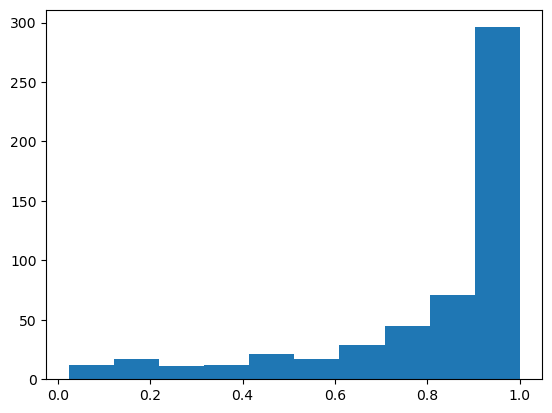

In [211]:
plt.hist(lead.hd_percentile)

(array([145.,  60.,  33.,  24.,  19.,  12.,   6.,   5.,   2.,  16.]),
 array([0.00198851, 0.10178966, 0.20159081, 0.30139195, 0.4011931 ,
        0.50099425, 0.6007954 , 0.70059655, 0.8003977 , 0.90019885,
        1.        ]),
 <BarContainer object of 10 artists>)

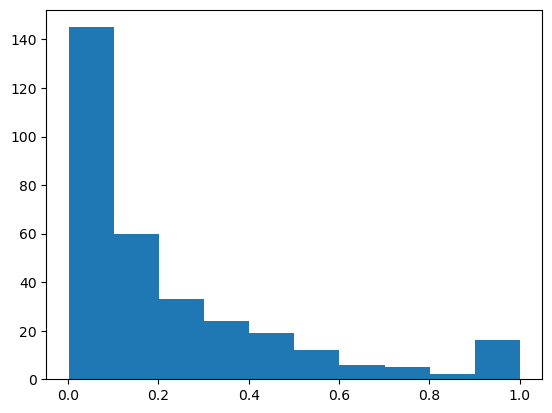

In [212]:
plt.hist(trail.hd_percentile)

(array([ 19.,  24.,  24.,  20.,  27.,  31.,  36.,  43.,  69., 254.]),
 array([0.00492914, 0.10443623, 0.20394331, 0.3034504 , 0.40295749,
        0.50246457, 0.60197166, 0.70147874, 0.80098583, 0.90049291,
        1.        ]),
 <BarContainer object of 10 artists>)

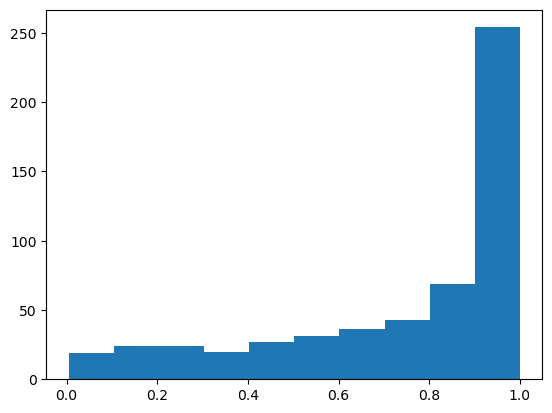

In [213]:
plt.hist(lead.raw_percentile)

(array([201.,  74.,  33.,  21.,  22.,  10.,  12.,   6.,   1.,  25.]),
 array([6.58197854e-05, 1.00059238e-01, 2.00052656e-01, 3.00046074e-01,
        4.00039492e-01, 5.00032910e-01, 6.00026328e-01, 7.00019746e-01,
        8.00013164e-01, 9.00006582e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

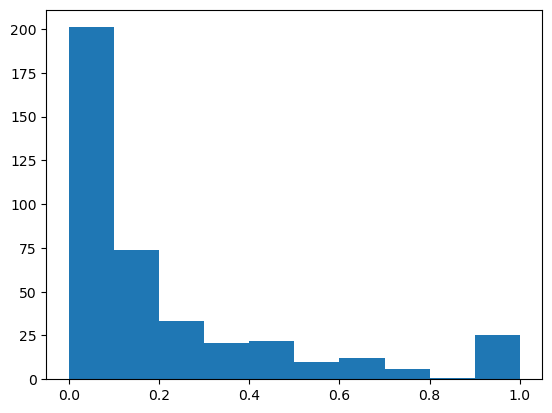

In [214]:
plt.hist(trail.raw_percentile)

In [215]:
import arviz as az
import numpy as np

In [216]:
az.hdi(np.array(lead.raw_percentile.dropna()), 0.60).round(2), az.hdi(np.array(trail.raw_percentile.dropna()), 0.60).round(2)

(array([0.78, 1.  ]), array([0.  , 0.15]))

In [217]:
az.hdi(np.array(lead.hd_percentile.dropna()), 0.60).round(2), az.hdi(np.array(trail.hd_percentile.dropna()), 0.60).round(2)

(array([0.87, 1.  ]), array([0.  , 0.18]))